In [1]:
import numpy as np 
import matplotlib.pyplot as plt

''' 
'''

class multiarmed_bandit:
    '''
    A flexible class, producing an object which acts as a bandit problem. 
    Arguments:
    k: number of arms/actions
    epsilon: probability of choosing non-greedy action
    iterations: number of iterations
    mu: mean values for actual rewards, which follow a defined theoretical probability distribution ["random", list of length k]
    action_value_method: the specified method for calculating the estimated rewards ["random", "weighted"]
    alpha: step size parameter for action value method "weighted"
    stationarity: indicates whether bandit problem shall behave stationary or non-stationary ["True","False"]
    initialisation: initial values for Q estimates ["default", "optimistic"]
    init_values: if initialisation == "optimistic", the model requires a list (length k) of initial values for Q estimates
    seed: integer value for random seed generation
    '''
    

    def __init__(
        self,
        k = 10,
        epsilon = 0,
        mu = "random", 
        iterations = 1000, 
        action_value_method = "average", 
        alpha = None, 
        stationarity = True, 
        initialisation = "default",
        init_values = None,
        seed = None):

        np.random.seed(seed)


        self.k = k
        self.alpha = alpha
        self.epsilon = epsilon
        self.iters = iterations
        self.n = 0 # initial step count
        self.action_n = np.zeros(k) # initial count for executing each of k actions/pulling arms

        # TRUE/REALIZED REWARDS
        # array for storing realized reward values
        self.realized_reward = None # empty variable for realized reward
        self.mean_reward = 0 # variable for mean reward over time 
        self.rewards = np.zeros(iterations) # storer for realized reward per iteration
        self.rewards_avg = np.zeros(iterations) # storer mean reward over time 
        

        ##### REWARD ESTIMATES Q(a) #####
        # initial values
        if initialisation == "default":
            self.q = np.zeros(k)
        elif initialisation == "optimistic" and isinstance(init_values, list):
            self.q =np.array(init_values)
        
        # defining method
        self.value_method = action_value_method

        # table for estimare tracking
        self.q_tracker = np.zeros((self.iters, self.k))


        # Expected values (mu) for rewards
        # if mu shall be gaussian rv, sampling mu from N(0,1)
        if mu == "random":
            self.mu = np.random.normal(0,1,k)
        
        #if mu is inputted as list, converting to np.array
        if isinstance(mu, list):
            self.mu = np.array(mu)


        # stationarity boolean + storer
        if stationarity == False:
            self.stationarity = False
            self.rw_increment = np.zeros(k)
        else:
            self.stationarity = True


        self.seed = seed

    def trigger(self):

        # generating a rv from binomial distribution with
        # P(rv = 1) = epsilon
        # rv=1 -> non-greedy execution
        # rv=0 -> greedy execution
        rv = np.random.binomial(1, self.epsilon, 1)


        # ACTION SELECTION
        # first iteration
        if self.n == 0:
            # randomly selects integer from array[0,...,k-1] with unit probability
            a = np.random.choice(self.k)
        
        # choosing greedy action if rv = 0
        elif rv == 0:
            a = np.argmax(self.q)

        # choosing non-greedy action of rv = 1
        elif rv == 1:
            a = np.random.choice(self.k)

        if self.stationarity == True:
            # sampling actual reward from respective gaussian -> N(mu_a, 1)
            self.realized_reward = np.random.normal(self.mu[a], 1)

        if self.stationarity == False:
            # adding random term to increment vector for random walk simulation
            self.rw_increment += np.random.normal(0,0.1, size = self.k) 
            self.realized_reward = np.random.normal(self.mu[a], 1) + self.rw_increment[a]


        # updating counts
        self.n += 1 
        
        self.action_n[a] += 1

        # calculating and updating mean reward
        self.mean_reward = self.mean_reward + (1/self.n) * (self.realized_reward - self.mean_reward)

        # ACTION SELECTION VALUE UPDATE
        # sample-average method (for stationary case)
        if self.value_method == "average":
            self.q[a] = self.q[a] + (1/self.action_n[a]) * (self.realized_reward - self.q[a])

        if self.value_method == "weighted":
            self.q[a] = self.q[a] + self.alpha * (self.realized_reward - self.q[a])
            

    def execute(self):
        # executing bandit for given iterations


        # loop over iterations/steps
        for i in range(self.iters):
            self.trigger()

            # storing results
            self.rewards[i] = self.realized_reward # storing the total realized reward in output vector
            self.rewards_avg[i] = self.mean_reward # storing the mean reward at t into corresponding storing vector
            self.q_tracker[i] = self.q

        out = {
            "realized rewards":self.rewards,
            "average rewards":self.rewards_avg,
            "q-estimates":self.q_tracker,
            "mu-values":self.mu,
            "action counter": self.action_n
        }

        return(out)
    
    # list of all statistics
    def stats(self):

        stats = {
            "realized rewards":self.rewards,
            "average rewards":self.rewards_avg,
            "q-estimates":self.q,
            "mu-values":self.mu,
            "action counter":self.action_n,
            "epsilon": self.epsilon,
            "mu values":self.mu,
            "action_value_method":self.value_method,
            "number of arms":self.k,
            "alpha":self.alpha,
            "epsilon": self.epsilon,
            "iterations": self.iters,
            "step count": self.n,
            "action count":self.action_n
        }

        return stats

    def tracking(self):
        out = {
            "test": self.q_tracker
        }


    # envorinment reset
    def reset(self):
        self.n = 0
        self.action_n = np.zeros(self.k)
        self.mean_reward = 0 
        self.realized_reward = 0 
        self.rewards_avg = np.zeros(self.iters)
        self.rewards = np.zeros(self.iters) # array for storing realized reward values
        self.q = np.zeros(self.k)
        self.q_tracker = np.zeros((self.iters, self.k))


In [ ]:
class visualiser:
    def __init__(self, bandit):
        self.results = bandit.execute()

    def total_rewards(self):
        plt.plot(self.results['realized rewards'])
        plt.show()


    def q_estimates(self):
        estimate_table = self.results["q-estimates"]
        for i in range(estimate_table.shape[1]):
            plt.plot(estimate_table[:,i], label = "Q(a = {})".format(i+1)) 

        plt.legend() 
        plt.show()

    def action_counts(self):
        fig, ax = plt.subplots()
        counts = self.results["action counter"]
        actions = [str(i+1) for i in list(range(counts["action counter"].shape[0]))]
        ax.bar(actions, counts)

        ax.set_ylabel('total count')
        ax.set_xlabel("action")
        ax.set_title('action counts')

        plt.show()
        
        

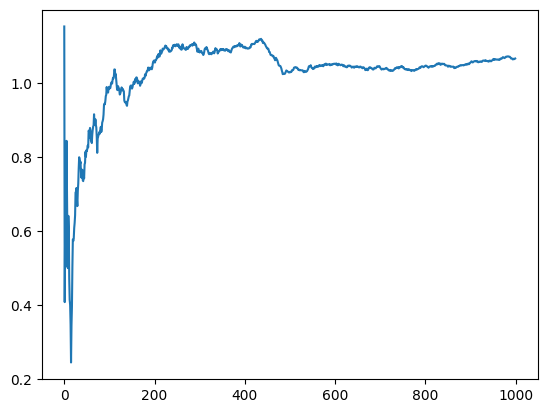

In [17]:

model = multiarmed_bandit(action_value_method="weighted", alpha = 0.6)
results = model.execute()
plot = plt.plot(results["average rewards"])
model.reset()

In [29]:
results["action counter"]

array([  1.,  25., 658.,  24.,  21.,   5., 193.,  71.,   1.,   1.])

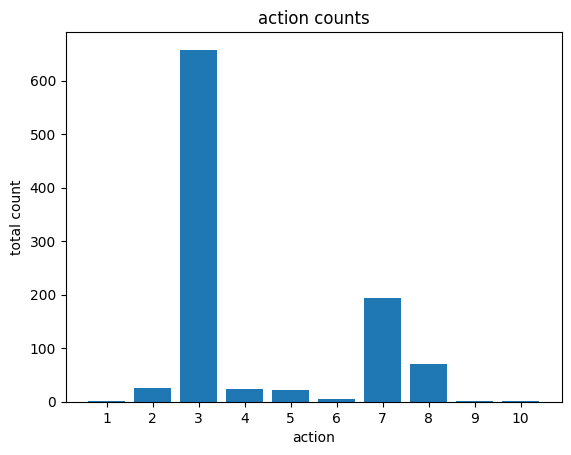

In [47]:
["action "+str(i+1) for i in list(range(results["action counter"].shape[1]))]

IndexError: tuple index out of range

In [50]:
results["action counter"].shape[0]

10

['action1',
 'action2',
 'action3',
 'action4',
 'action5',
 'action6',
 'action7',
 'action8',
 'action9',
 'action10']